# Generating Models to Data
## Author:  Dominic Doud (NASA Ames Research Center)

After installing picaso (which can be found [here](https://natashabatalha.github.io/picaso/installation.html)), run the previous notebook [AnalyzeExoplanet_picaso_setup.ipynb](https://colab.research.google.com/drive/1zPjFDy8HTy4nwsFbAbq73UJMZkTMZGCT?usp=sharing) to download the example data.  The setup notebook needs to just be run **once**. 

**NOTE: This tutorial is aimed at both beginner and advanced levels.**

# Check PICASO Imports

Here are the two main PICASO functions you will be exploring:

`justdoit` contains all the spectroscopic modeling functionality you will need in these exercises.

`justplotit` contains all the of the plotting functionality you will need in these exercises.

Tips if you are not familiar with Python or `jupyter notebooks`:

- Run a cell by clicking shift-enter. You can always go back and edit cells. But, make sure to rerun them if you edit it. You can check the order in which you have run your cells by looking at the bracket numbers (e.g. [1]) next to each cell.

- In any cell you can write `help(INSERT_FUNCTION)` and it will give you documentation on the input/output

- If you type `jdi.` followed by "tab" a box will pop up with all the available functions in `jdi`. This applies to any python function (e.g. `numpy`, `pandas`)
  
- If you type class.function?, for example `jdi.mean_regrid`, it will describe the function and it's parameters/returns. This also applies to any class with a function

## Define the directory

We have created a special condensed version of all the picaso and virga ref data, that includes everything you need to complete this exercise. **All you need to do is define your path picaso_tutorial_dir for Python, the same as the setup notebook**

In [1]:
import os
#check you have picaso
from picaso import justdoit as jdi
from picaso import justplotit as jpi
import picaso.opacity_factory as op
import numpy as np

jpi.output_notebook()
# define the same directory you did in the setup, where you have extracted the example data files
picaso_tutorial_dir = 'exoplanet_modeling_tutorial'

Loading BokehJS ...

In [2]:
#check you have picaso
from picaso import justdoit as jdi
from picaso import justplotit as jpi
import picaso.opacity_factory as op
import numpy as np

jpi.output_notebook()

Loading BokehJS ...

Triple check that paths are being set correctly

In [3]:
#double check that your reference file path has been set
import os
refdata = os.getenv("picaso_refdata")
print(refdata)
#if you are having trouble setting this you can do it right here in the command line
#os.environ["picaso_refdata"]= add your path here AND COPY AND PASTE ABOVE
#IT WILL NEED TO GO ABOVE YOUR PICASO IMPORT

/data/reference_data/picaso/reference


# Observed Spectrum

Before we start modeling a planet to match WASP-39 b, let's get hold of WASP-39 b's actual observed spectrum in data format, so we can plot it next to our modeled ones. If you did [part 1 of this tutorial](https://github.com/Kappibw/JWST/blob/main/2_retrieving_jwst_spectra.ipynb), you already downloaded the data prepared by the scientists who wrote [the CO2 discovery paper](https://arxiv.org/pdf/2208.11692.pdf).

If you haven't done part 1, you can download the data from [here](https://zenodo.org/record/6959427#.Yx936-zMJqv). Download the .zip, and then look for `ZENODO/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt`.
**This file was downloaded as part of the Setup notebook.**

Or you can take your own reducted data.

In [4]:
eureka_reduction_path = picaso_tutorial_dir+'/ZENODO/TRANSMISSION_SPECTRA_DATA/EUREKA_REDUCTION.txt'

In [5]:
# import ascii
from astropy.io import ascii

# Confirm can read the file
observed_data = ascii.read(eureka_reduction_path)

In [6]:
observed_data.colnames

['wavelength',
 'bin_width',
 'tr_depth',
 'tr_depth_errneg',
 'tr_depth_errpos',
 'ecl_depth',
 'ecl_depth_errneg',
 'ecl_depth_errpos']

Let's plot the observed data and see what we are working with!

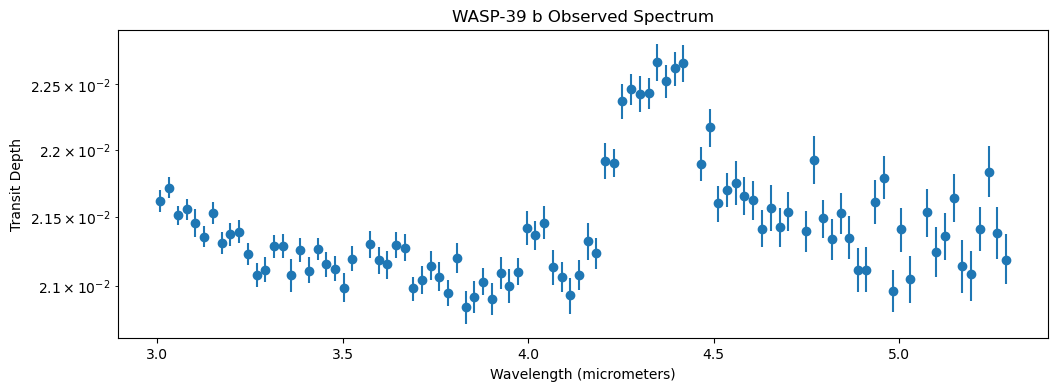

In [7]:
plt=jpi.plt
plt.figure(figsize=(12,4))
plt.errorbar(observed_data['wavelength'], observed_data['tr_depth'],
             [observed_data['tr_depth_errneg'], observed_data['tr_depth_errpos']],fmt='o')
plt.title('WASP-39 b Observed Spectrum')
plt.yscale('log')
plt.ylabel('Transit Depth')
plt.xlabel('Wavelength (micrometers)')
plt.show()

# Spectra Ingredients

Now what? Let's slowly build up a model that can match this data. What do we need?

## PICASO Basics


### List of what you will need before getting started

1. Planet properties

- planet radius
- planet mass
- planet's equilibrium temperature

2. Stellar properties

- stellar logg
- stellar effective temperature
- stellar metallicity

3. Opacities (how do molecules and atoms absorb light under different pressure temperature conditions)



# Basic Inputs

## Cross Section Connection

All rapid radiative transfer codes rely on a database of pre-computed cross sections. Cross sections are computed by using line lists in combination with critical molecular pressure broadening parameters. Both can either be derived from theoretical first principles (e.g. [UCL ExoMol's line lists](https://www.exomol.com/)), measured in a lab, and/or some combination thereof (e.g. [HITRAN/HITEMP line lists](https://hitran.org/)).

When cross sections are initially computed, a resolution ($\lambda/\Delta \lambda$) is assumed. Cross sections are computed on a line-by-line nature and therefore usually computed for R~1e6. For JWST we are often interested in large bands (e.g. 1-14 $\mu$m). Therefore we need creative ways to speed up these runs. You will usually find one of two methods: correlated-k tables, and resampled cross sections. [Garland et al. 2019](https://arxiv.org/pdf/1903.03997.pdf) is a good resource on the differences between these two.

For this demonstration we will use the resampled cross section method. **The major thing to note about using resampled cross sections** is that you have to compute your model at ~100x higher resolution that your data. You will note that the opacity file you downloaded is resampled at R=10,000. Therefore you will note that **in this tutorial we will always bin it down to R=100**.

**The overall idea is that we are just simply intializing PICASO to operate, create a "connection" to the models/spectral tools, in that wavelength (in microns) with the respective opacity range.**

In [8]:
opa = jdi.opannection(wave_range=[2.7,6])

## Set Basic Planet and Stellar Inputs

Second step is to define the basic planet parameters. Depending on the kind of model you want to compute (transmission vs emission vs reflected light) there are different requirements for the minimum set of information you need to include.

For WASP-39b since we have both planet mass, and radius, and all the necessary stellar specifications for our parameters, we will be thorough in our inputs and include all parameters.

The overall idea is that we create an object, where the main planet is what we focus on. This is like a "case", where we are only analyzing this planet. It is best to think about it like creating a scenario where only this planet and star exists. In that object or case, we define the specifications of the star and planet, then we can do all of our climate methods in that object. That way, everything and all the work is wrapped in that one object!

In [9]:
#create that object or "case"
w39 = jdi.inputs()

#describe the star 
w39.star(opa, temp=5400 , database='phoenix',
         metal=0.01, logg=4.45, radius=0.9, radius_unit=jdi.u.R_sun )

#describe the planet
w39.gravity(mass=0.28, mass_unit=jdi.u.M_jup,
             radius=1.27, radius_unit=jdi.u.R_jup)


In [10]:
# To get information about a function, you can use '?'
w39.star?

Signature:
w39.star(
    opannection,
    temp=None,
    metal=None,
    logg=None,
    radius=None,
    radius_unit=None,
    semi_major=None,
    semi_major_unit=None,
    database='ck04models',
    filename=None,
    w_unit=None,
    f_unit=None,
)
Docstring:
Get the stellar spectrum using pysynphot and interpolate onto a much finer grid than the 
planet grid. 

Parameters
----------
opannection : class picaso.RetrieveOpacities
    This is the opacity class and it's needed to get the correct wave info and raman scattering cross sections
temp : float 
    (Optional) Teff of the stellar model if using the stellar database feature. 
    Not needed for filename option. 
metal : float 
    (Optional) Metallicity of the stellar model if using the stellar database feature. 
    Not needed for filename option. 
logg : float 
    (Optional) Logg cgs of the stellar model if using the stellar database feature. 
    Not needed for filename option. 
radius : float 
    (Optional) Radius of the s

## Climate and Chemistry

We now need to think about how we can model the climate and chemistry of this system. For the sake of this tutorial we will start really simple, then move forward to something more complex.

**For climate**, we will explore these levels in this tutorial

1. Isothermal (now)
2. Radiative-convective (next section)

**For chemistry**, we will explore these levels in this tutorial

1. Chemical Equilibrium


#### Pressure
If we imagine our "nlevels" as equally spaced altitude bands on the planet, then we will assign pressures to decrease logarithmically as altitude increases.

Gas is compressible and tends to behave in that way in planetary atmospheres (including earth).

In [11]:
nlevels = 50
# Logspace goes from base^(start) to base^(end)
# so here we are going from 10^-6 to 10^2, which is
# 1 microbar to 100 bars of pressure.
# this is an arbitrarily chosen range, but this is the most common
pressure = np.logspace(-6,2,nlevels)

### Isothermal Temperature

For our corresponding temperature values, we are going to start out with keeping temperature constant as we increase levels, which is called "isothermal". This is a big simplification but is something we can compare to when we get more sophisticated.

In [12]:
# We can see from exo.MAST that the equilibrium temp
# of WASP 39 b is 1120 kelvin, so let's use a scale
# around that of temperatures.
equilibrium_temperature = 1120.55
isothermal_temperature = np.zeros(nlevels) + equilibrium_temperature

#### Setting the Atmosphere in PICASO

Finally, let's define the atmosphere in the `w39` case. Keep note that we have described the parent star, planet and now the atmosphere. This workflow of creating a case and add parameters (information) about the environment as we go is important to note.

In [13]:
w39.atmosphere(df = jdi.pd.DataFrame({
                'pressure':pressure,
                'temperature':isothermal_temperature}))

### Combing parameterized climate with chemistry

Now we need to add the chemistry! PICASO has a prebuilt chemistry table that was computed by Channon Visscher. You can use it by adding it to your input case. Two more chemistry parameters are now going to be introduced:

1. C/O ratio: Elemental carbon to oxygen ratio
2. M/H: Atmospheric metallicity


#### Metallicity

<img src="https://stellarplanetorg.files.wordpress.com/2020/04/wakeforddalba2020_rs_mass_metallicity_v1.jpg?w=736" width="800">

Looking at mass-metallicity might offer a good starting point to decide what the M/H of your planet might be. Here we can see Wasp-39b HST observations led to the inference of ~100xM/H. One tactic might be to start from that estimate. Another might be to use the Solar System extrapolated value as a first pass. Let's start with the latter as a first guess.

In [14]:
log_mh = 1.0 #log relative to solar, so 10^0 here = 1x solar.

#### C/O Ratio

The elemental ratio of Carbon to Oxygen controls the dominant carbon-bearing species. For instance take a look at figure 1 from the paper [C/O RATIO AS A DIMENSION FOR CHARACTERIZING EXOPLANETARY ATMOSPHERES](https://iopscience.iop.org/article/10.1088/0004-637X/758/1/36/pdf)

At low C/O, we see CO2 and CO as the dominant form of carbon, and at high C/O we see CH4 and CO as the dominant form of carbon.

C/O is also given in PICASO in units relative to solar C/O, which is worth noting because you're not giving it the actual ratio of Carbon to Oxygen, but rather the ratio relative to the Solar C/O, which is ~0.5.

In [15]:
c_o = 1 #relative to solar

Now we can ask PICASO to make us a mixture of molecules consistent with the Metallicity and CO we set up, and we can take a look at what it creates. We can look at the "atmosphere profile" which shows us the abundances of various molecules at different levels of our atmosphere (levels being places where temperature and pressure differ in the manner we defined above). 

This can help us find out which molecules we should really focus on during our analysis, and others that may be harder and redudant to look for based off of our CtO ratio and metallicity.

In [16]:
w39.chemeq_visscher(c_o, log_mh)

You can see that PICASO has given us loads of different molecules to work with, but many have miniscule abundances (note some e-38 values in there). 

We will unpack this chemistry later in the tutorial, but for now we can stick with this black-box equilibrium setup.

### Reference Pressure

Lastly, we need to decide on a "reference pressure". If our planet was terrestrial, this would be the pressure at the surface, and therefore also the pressure corresponding to the radius of the planet. For gas giants like WASP-39 b this is a bit more complicated- there is no "surface", so we need to pick a pressure that corresponds to our planet's "radius" or surface, so that PICASO can calculate gravity as a function of altitude from that level.

We are selecting a pressure that we essentially calling the bottom.

As we've discussed, a planet's radius changes depending on the wavelength at which you observe it- it's that change that we are measuring with our spectra. But when we input the planet radius above, we picked a single number- 1.27 `r_jup`. That number is an average calculated over a band of wavelengths, and so when we pick a reference pressure, we estimate roughly what level of the planet's atmosphere that averaged radius corresponds to (where, from the high pressure deep inside, to the low pressure at the exterior, does the chosen radius fall?).

PICASO suggests a reference pressure of 10 bar for gas giants, so we will start with that:

In [17]:
w39.approx(p_reference=10)

### Want to check your inputs so far?

If you want you can consult `w39.inputs` to check or reset inputs. Let's see how our Wasp-39B object is holding up!

In [18]:
w39.inputs.keys()

dict_keys(['version', 'calculation', 'phase', 'planet', 'climate', 'star', 'atmosphere', 'clouds', 'approx', 'disco', 'opacities', 'test_mode', 'output_dir'])

In [19]:
w39.inputs['atmosphere']['profile'].head()

pressure  temperature            e-        H2         H            H+  \
0  0.000001      1120.55  9.490315e-10  0.829371  0.000037  4.505256e-38   
1  0.000001      1120.55  7.790618e-10  0.829372  0.000031  4.505298e-38   
2  0.000002      1120.55  6.395334e-10  0.829374  0.000025  4.505340e-38   
3  0.000003      1120.55  5.249653e-10  0.829375  0.000021  4.505378e-38   
4  0.000004      1120.55  4.306428e-10  0.829377  0.000017  4.505378e-38   

             H-           H2-           H2+           H3+  ...            Cs  \
0  1.537986e-18  8.816532e-28  4.505256e-38  4.505256e-38  ...  1.249933e-10   
1  1.523700e-18  1.054149e-27  4.505298e-38  4.505298e-38  ...  1.189188e-10   
2  1.509547e-18  1.260395e-27  4.505340e-38  4.505340e-38  ...  1.131394e-10   
3  1.495432e-18  1.506887e-27  4.505378e-38  4.505378e-38  ...  1.076439e-10   
4  1.480360e-18  1.800108e-27  4.505378e-38  4.505378e-38  ...  1.024490e-10   

        CO2           HCN          C2H2          C2H4          C2H6  \
0  0.000018  4.153731e-14  9.628886e-23  3.709806e-27  1.310189e-33   
1  0.000018  6.050700e-14  2.043128e-22  1.146517e-26  5.897597e-33   
2  0.000018  8.813998e-14  4.335259e-22  3.543317e-26  2.654705e-32   
3  0.000018  1.283903e-13  9.198541e-22  1.095008e-25  1.194894e-31   
4  0.000018  1.869807e-13  1.950916e-21  3.381929e-25  5.374143e-31   

            SiO           MgH           OCS      graphite  
0  7.121062e-08  1.997696e-16  4.806553e-08  4.500000e-38  
1  4.889768e-08  1.655482e-16  5.090137e-08  4.500000e-38  
2  3.357622e-08  1.371890e-16  5.390453e-08  4.500000e-38  
3  2.305577e-08  1.136884e-16  5.695836e-08  4.500000e-38  
4  1.583354e-08  9.421812e-17  5.863542e-08  4.500000e-38  

[5 rows x 36 columns]

In [20]:
#grab CO2 array, for instance
w39.inputs['atmosphere']['profile']['CO2'].values

array([1.79267873e-05, 1.79249913e-05, 1.79231956e-05, 1.79214685e-05,
       1.79205465e-05, 1.79196245e-05, 1.79187025e-05, 1.79177025e-05,
       1.79166913e-05, 1.79156802e-05, 1.79149708e-05, 1.79142762e-05,
       1.79135817e-05, 1.79130064e-05, 1.79124708e-05, 1.79119353e-05,
       1.79116995e-05, 1.79115258e-05, 1.79113521e-05, 1.79111679e-05,
       1.79109774e-05, 1.79107869e-05, 1.79107304e-05, 1.79107304e-05,
       1.79107304e-05, 1.79111051e-05, 1.79118546e-05, 1.79126042e-05,
       1.79168402e-05, 1.79236197e-05, 1.79304018e-05, 1.79541807e-05,
       1.80063886e-05, 1.80587482e-05, 1.80587902e-05, 1.79957721e-05,
       1.79329740e-05, 1.72447325e-05, 1.49014162e-05, 1.28765235e-05,
       9.97526332e-06, 6.18030943e-06, 3.82909438e-06, 2.30984178e-06,
       1.15576774e-06, 5.78307604e-07, 2.86382257e-07, 1.36176533e-07,
       6.47527829e-08, 3.07903484e-08])

In [21]:
w39.inputs['planet'], w39.inputs['star']#all your inputs have been archived!

({'gravity': 430.29483869562654,
  'gravity_unit': 'cm/(s**2)',
  'radius': 9079484000.0,
  'radius_unit': 'cm',
  'mass': 5.3147488725409414e+29,
  'mass_unit': 'g'},
 {'database': 'phoenix',
  'temp': 5400,
  'metal': 0.01,
  'logg': 4.45,
  'radius': 62613000000.0,
  'radius_unit': 'cm',
  'flux': array([1.24415361e+12, 1.24431541e+12, 1.24449255e+12, ...,
         1.50352227e+13, 1.51554262e+13, 1.52756417e+13]),
  'flux_unit': 'ergs cm^{-2} s^{-1} cm^{-1}',
  'wno': array([1886.79174527, 1886.98043388, 1887.16914136, ..., 3702.75781495,
         3703.12810925, 3703.49844058]),
  'semi_major': nan,
  'semi_major_unit': 'Semi Major axis not supplied',
  'filename': None,
  'w_unit': None,
  'f_unit': None})

# Creating a Transmission Spectrum

Now we have set up PICASO with everything it needs, and we understand the components needed to model an exoplanet, let's ask PICASO to output a transmission spectrum for our WASP-39 b.

## First Run PICASO

We can use the <code>.spectrum</code> function to do so.

We need to give the function a connection to the opacity database we used earlier to look up the absorption spectrum for water, as well as an instruction to create a "transmission" spectrum (as opposed to, for example, a reflected light spectrum of star light bouncing off the planet when it's almost behind its star).

In [22]:
model_iso = w39.spectrum(opa,
                       #other options are 'thermal' or "reflected"
                       #or a combination of two e.g. "transmmission+thermal"
                       calculation='transmission',
                       full_output=True)


## Our Spectra

Let's set up a function to display all the spectra in our `planets` dictionary, so we can easily add more and compare them.

In [23]:
def show_spectra(output, x_range_min=3.0, x_range_max=5.5):
    #Step 1) Regrid model to be on the same x axis as the data
    wnos, rprs2s = jdi.mean_regrid(output['wavenumber'],
                                         output['transit_depth'],
                                         newx=sorted(1e4/observed_data['wavelength']))

    # Step 2) Use picaso function to create a plot with the models
    fig = jpi.spectrum(wnos, rprs2s,
                       plot_width=800,
                       x_range=(x_range_min,x_range_max))

    # Step 3) Use picaso function to add the data so we can compare
    jpi.plot_multierror(observed_data['wavelength'], observed_data['tr_depth'], fig,
                        dy_low=observed_data['tr_depth_errneg'], dy_up=observed_data['tr_depth_errpos']
                        , dx_low=[0],dx_up=[0], point_kwargs={'color':'black'})
    jpi.show(fig)

In [24]:
# Display our first spectra!
show_spectra(model_iso)

Sweet! We have spectra that look the right-ish shape, even though they aren't quite in the right place. Let's take a minute to work that out.

### Transit Depth Offsets

Remember how we guessed what the reference pressure was ? Well it looks like we are a little off. That is okay! When fitting for transit spectra, we introduce a factor to account for this. In the retrieval tutorial, you will fit for a factor of the radius. For now let's "mean subtract" our data so that they lie on top of each other.

In [25]:
#let's mean subtract these
def show_spectra(output, x_range_min=3.0, x_range_max=5.5):
    #Step 1) Regrid model to be on the same x axis as the data
    wnos, rprs2s = jdi.mean_regrid(output['wavenumber'],
                                         output['transit_depth'],
                                         newx=sorted(1e4/observed_data['wavelength']))

    # Step 2) Use picaso function to create a plot with the models
    fig = jpi.spectrum(wnos, rprs2s-np.mean(rprs2s),
                       plot_width=800,
                       x_range=(x_range_min,x_range_max))

    # Step 3) Use picaso function to add the data so we can compare
    jpi.plot_multierror(observed_data['wavelength'],
                        observed_data['tr_depth'] - np.mean(observed_data['tr_depth']),
                        fig,
                        dy_low=observed_data['tr_depth_errneg'], dy_up=observed_data['tr_depth_errpos']
                        , dx_low=[0],dx_up=[0], point_kwargs={'color':'black'})
    jpi.show(fig)

In [26]:
show_spectra(model_iso)

## Model Investigation

Before trying to improve the complexity of your model, let's make sure you know how to analyze the inputs.

### Identifying molecular features with optical depth contribution plot

`taus_per_layer` - Each dictionary entry is a nlayer x nwave that represents the per layer optical depth for that molecule.

`cumsum_taus` - Each dictionary entry is a nlevel x nwave that represents the cumulative summed opacity for that molecule.

`tau_p_surface` - Each dictionary entry is a nwave array that represents the pressure level where the cumulative opacity reaches the value specified by the user through at_tau.



Let's create a molecule contribution plot, where we can see at what wavelengths is each molecule present at a certain Tau Pressure

In [27]:
molecule_contribution = jdi.get_contribution(w39, opa, at_tau=1)

In [28]:
jpi.show(jpi.molecule_contribution(molecule_contribution,
                                   opa, plot_width=700, x_axis_type='log'))

### Identifying molecular features with "leave-one-out" method

Another option for investigating model output is to remove the contribution of one gas from the model to see if it affects our spectrum. CO$_2$ was a fairly obvious feature for the 4.3$\mu$m. Let's take the blended features that you identified from 4.4-6$\mu$m as an example.

In [29]:
w,f,l =[],[],[]
df_og = jdi.copy.deepcopy(w39.inputs['atmosphere']['profile'])
for iex in ['H2O','CO',None]:
    w39.atmosphere(df=df_og,exclude_mol=iex, delim_whitespace=True)
    df= w39.spectrum(opa, full_output=True,calculation='transmission') #note the new last key
    wno, rprs2  = df['wavenumber'] , df['transit_depth']
    wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)
    w +=[wno]
    f+=[rprs2]
    if iex==None:
        leg='all'
    else:
        leg = f'No {iex}'
    l+=[leg]
jpi.show(jpi.spectrum(w,f,legend=l))

We can see clearly that when H$_2$O or CO is not present, it veers off the model and creates a completely different spectrum. This is giving us a good sign that we can clearly see H$_2$O and CO.

# Increasing Model Complexity to Improve Fit

In the next sections we will try to improve our model fit. However, before we continue we need a way to quantify our "goodness of fit".

## Define Goodness of Fit

Let's implement a simple measurement of error called "reduced-chi-squared". This is a commonly used method to measure how well you are fitting data with a model, and sums up the distance between your output and the observed data at each data point. We want chi squared to be close to 1.

In [30]:
def chisqr(model):
    #Step 1) Regrid model to be on the same x axis as the data
    wnos, model_binned = jdi.mean_regrid(model['wavenumber'],
                                         model['transit_depth'],
                                         newx=sorted(1e4/observed_data['wavelength']))
    #Step 2) Flip model so that it is increasing with wavelenght, not wavenumber
    model_binned = model_binned[::-1]-np.mean(model_binned)

    #step 3) Compute chi sq with mean subtraction
    observed = observed_data['tr_depth'] - np.mean(observed_data['tr_depth'])
    error = (observed_data['tr_depth_errneg'] + observed_data['tr_depth_errpos'])/2
    return np.sum(((observed-model_binned)/error)**2 ) / len(model_binned)

In [31]:
print('Simple First Guess', chisqr(model_iso))

Simple First Guess 22.094307587786016


Not great! Let's make it better.

## Revisiting Chemistry Assumption

Before we assumed M/H and C/O values. Let's loop through a few M/H and C/O values to see if any of these seem to improve our model fit. Why? Faster than climate and clouds and easy to loop through and build intuition. We want to find the best "grid" of variables (C/O, M/H) that will gives us the closest fit to the data.

In [32]:
mh_grid_vals = [1, 10,100]
co_grid_vals = [1,2.5]

chemistry_grid = {}
for imh in mh_grid_vals:
    for ico in co_grid_vals:
        w39.chemeq_visscher(ico, np.log10(imh))
        chemistry_grid[f'M/H={imh},C/O={ico}'] = w39.spectrum(opa, calculation='transmission', full_output=True)
        print(f'M/H={imh},C/O={ico}', chisqr(chemistry_grid[f'M/H={imh},C/O={ico}'] ))

M/H=1,C/O=1 17.010154161392208
M/H=1,C/O=2.5 46.81023164385187
M/H=10,C/O=1 22.094307587786016
M/H=10,C/O=2.5 28.578448173015293
M/H=100,C/O=1 4.76088469275039
M/H=100,C/O=2.5 12.065884741389864


We see with a M/H of 100 and C/O of 1.4, we get the best fit where the chi-squared is 4.76. Let's plot all these and visually confirm.

In [33]:
#let's edit our function once again to allow for multiple model inputs
def show_spectra(output, x_range_min=3.0, x_range_max=5.5):
    #Step 1) Regrid model to be on the same x axis as the data
    wnos, rprs2s = zip(*[jdi.mean_regrid(output[x]['wavenumber'], output[x]['transit_depth'],
                        newx=sorted(1e4/observed_data['wavelength']))
                        for x in output])
    rprs2s = [x-np.mean(x) for x in rprs2s]
    wnos = [x for x in wnos]
    legends = [i for i in output]

    # Step 2) Use picaso function to create a plot with the models
    fig = jpi.spectrum(wnos, rprs2s, legend=legends,
                       plot_width=800,
                       x_range=(x_range_min,x_range_max))

    # Step 3) Use picaso function to add the data so we can compare
    jpi.plot_multierror(observed_data['wavelength'],
                        observed_data['tr_depth'] - np.mean(observed_data['tr_depth']),
                        fig,
                        dy_low=observed_data['tr_depth_errneg'], dy_up=observed_data['tr_depth_errpos']
                        , dx_low=[0],dx_up=[0], point_kwargs={'color':'black'})
    jpi.show(fig)

In [34]:
show_spectra(chemistry_grid)

## Revisiting Climate Assumption

1D Radiative-Convective Equilibrium Models solve for atmospheric structures of brown dwarfs and exoplanets, which includes:

1\. The Temperature Structure (T(P) profile)

2\. The Chemical Structure


But these physical components are not independent of each other. For example, the chemistry is dependent on the T(P) profile.

`PICASO` tries to find the atmospheric state of your object by taking care of all of these processes and their interconnections self-consistently and iteratively. Therefore, you will find that the climate portion of `PICASO` is slower than running a single forward model evaluation.

### Starting a climate run

#### Correlated-K Tables

Before when we created a model atmosphere run we need to edit our call to `opannection`. For climate calculations we need to make sure that we are covering the full range of the planetary energy distribution, which usually amounts to ~0.3-300 $\mu$m. This would be prohibitively slow if we used our same monochromatic opacities. Therefore, we instead use correlated-k tables which are on a very low resolution grid with only 196 wavelength points spanning 0.3-300 $\mu$m. We compute these correlated-K tables **as a function of M/H and C/O**. Therefore, unlike before, we are setting the chemistry of our calculation up front by specifying the correlated-K table.


In [35]:
mh = '+100'#'+1.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio
#ck_dir = 'your-path-to-correlated-tables'
ck_dir='/data/kcoeff_2020_v3/'
ck_db = os.path.join(ck_dir,
                     f'sonora_2020_feh{mh}_co_{CtoO}.data.196')

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities



#### Effective and Intrinsic Temperatures

You will notice that starting a run is nearly identical as running a spectrum. However, how we will add `climate=True` to our inputs flag, telling PICASO to create a climate. Let's create a new object or "case" where we are running the exact same parameters of the star, planet but now we are going to end with the goal of having a climate model.

New Parameter: **Effective Temperature**. This excerpt from [Modeling Exoplanetary Atmospheres (Fortney et al)](https://arxiv.org/pdf/1804.08149.pdf) provides a thorough description and more reading, if you are interested.

>If the effective temperature, $T_{eff}$, is defined as the temperature of a blackbody of
the same radius that would emit the equivalent flux as the real planet, $T_{eff}$ and $T_{eq}$
can be simply related. This relation requires the inclusion of a third temperature,
$T_{int}$, the intrinsic effective temperature, that describes the flux from the planet’s
interior. These temperatures are related by:"

>$T_{eff} =  T_{int} + T_{eq}$

>We then recover our limiting cases: if a planet is self-luminous (like a young giant
planet) and far from its parent star, $T_{eff} \approx  T_{int}$; for most rocky planets, or any
planets under extreme stellar irradiation, $T_{eff} \approx T_{eq}$.


In [36]:
cl_run = jdi.inputs(calculation="planet", climate = True) # start a calculation

semi_major = 0.0486 # star planet distance, AU
cl_run.star(opacity_ck, temp=5400 , database='phoenix',
         metal=0.01, logg=4.45, radius=0.9, radius_unit=jdi.u.R_sun ,
            #note, now we need to know the planet-star separation!
         semi_major= semi_major , semi_major_unit = jdi.u.AU)


cl_run.gravity(mass=0.28, mass_unit=jdi.u.M_jup,
             radius=1.27, radius_unit=jdi.u.R_jup)

# Intrinsic Temperature of your Planet in K
# let's keep this fixed for now
tint= 200
cl_run.effective_temp(tint) # input intrinsic temperature


### Initial T(P)  Guess

Every calculation requires an initial guess of the pressure temperature profile. The code will iterate from there to find the correct solution. A few tips:

1. We recommend **using typically 51-91 atmospheric pressure levels**. Too many pressure layers increases the computational time required for convergence. Too little layers makes the atmospheric grid too coarse for an accurate calculation.

2. Start with **a guess that is close to your expected solution**. One easy way to get fairly close is by using the Guillot et al 2010 temperature-pressure profile approximation


In [37]:
nlevel = 91 # number of plane-parallel levels in your code

#Lets set the max and min at 1e-4 bars and 500 bars
pt = cl_run.guillot_pt(equilibrium_temperature, nlevel=nlevel, T_int = tint, p_bottom=2, p_top=-6)
temp_guess = pt['temperature'].values
pressure = pt['pressure'].values

### Initial Convective Zone Guess

You also need to have a crude guess of the convective zone of your atmosphere. Generally the deeper atmosphere is always convective. Again a good guess is always the published SONORA grid of models for this. But lets assume that the bottom 7 levels of the atmosphere is convective.

**New Parameters:**

1. `nofczns` : Number of convective zones. Though the code has functionality to solve for more than one. In this basic tutorial, let's stick to 1 for now.
2. `rfacv`: (See Mukherjee et al Eqn. 20 `r_st`) https://arxiv.org/pdf/2208.07836.pdf

Non-zero values of rst (aka "rfacv" legacy terminology) is only relevant when the external irradiation on the atmosphere is non-zero. In the scenario when a user is computing a planet-wide average T(P) profile, the stellar irradiation is contributing to 50% (one hemisphere) of the planet and as a result rfacv = 0.5. If instead the goal is to compute a night-side average atmospheric state, rfacv is set to be 0. On the other extreme, to compute the day-side atmospheric state of a tidally locked planet rfacv should be set at 1.

In [38]:
nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr_upper = 85 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.5 #let's assume perfect heat redistribution

Now we would use the inputs_climate function to input everything together to our cl_run we started.

In [39]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv)

### Run the Climate Code

 The actual climate code can be run with the cl_run.run command. The save_all_profiles is set to True to save the T(P) profile at all steps. The code will now iterate from your guess to reach the correct atmospheric solution for your exoplanet.

This will take a few minutes (~3 to 10 min)

In [40]:
clima_out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Iteration number  0 , min , max temp  951.9261188112152 2444.7635140401717 , flux balance  355.48272819298694
Iteration number  1 , min , max temp  846.1715100178089 2739.412532350148 , flux balance  49.84593598919913
Iteration number  2 , min , max temp  824.1684926850036 2688.576262289368 , flux balance  2.3737070823566477
Iteration number  3 , min , max temp  823.1635675826317 2686.496004127008 , flux balance  0.021271004026151227
In t_start: Converged Solution in iterations  3
Big iteration is  823.1635675826317 0
Iteration number  0 , min , max temp  822.2698937087596 2717.3336599204276 , flux balance  78.79082299481236
Iteration number  1 , min , max temp  817.4204361962569 2861.0655154766055 , flux balance  4.870943618816423
Iteration number  2 , min , max temp  817.3428512208624 2848.7806395166035 , flux balance  0.05694914646967843
Iteration number  3 , min , max temp  817.3422948318339 2848.6457744923196 , flux balance  0.00029679394119951405
In t_start: Converged Solution in

Let's visually confirm the convergence through a plot animation

In [41]:
ani = jpi.animate_convergence(clima_out, cl_run, opacity_ck,
                              calculation='transmission',
    molecules=['H2O','CH4','CO','CO2'])

In [42]:
ani

Nice ! Our initial parameterized guess wasn't too far from the final converged solution. Let's add this climate pressure-temperature chemical information we just made back to our original WASP-39b object or "case", and see how it affects our spectrum.

In [43]:
#let's go back to our initial object or "case" that we were using for our transit sepctra.
w39.atmosphere(df=clima_out['ptchem_df'])
df_spec = w39.spectrum(opa, calculation='transmission', full_output=True)
show_spectra({'clima':df_spec})

print(f'Converged Climate Model Chi sq=', chisqr(df_spec ))

Converged Climate Model Chi sq= 13.026155858456619


### Add manual chemistry to model

Let's create an object or "case" where SO$_2$ is present and see if that will create a model with a better fit to the data.

In [47]:
so2_case = jdi.copy.deepcopy(w39)
#let's consider again our simple cloud case
so2_case.clouds(p=[1], dp=[4.5], opd=[1], g0=[0], w0=[0])

#let's explore
so2_abundnace = [1e-7,1e-6,1e-5]
so2_models = {}
for iso2 in so2_abundnace:
    so2_case.inputs['atmosphere']['profile']['SO2']=iso2
    df_spec_so2 = so2_case.spectrum(opa, calculation='transmission',full_output=True)
    so2_models[f'{iso2}']=df_spec
    print(f'Chi-Sq of SO2={iso2}:' ,chisqr(df_spec))
show_spectra(so2_models)

Chi-Sq of SO2=1e-07: 13.026155858456619
Chi-Sq of SO2=1e-06: 13.026155858456619
Chi-Sq of SO2=1e-05: 13.026155858456619


# Xarray output (.nc) the model

Now that we have our models created and all done, let's save our climate model as an [Xarray](https://docs.xarray.dev/en/stable/). This is a great tool to neatly wrap all of your models. This is very useful because we can continue our analysis from low-fidelty PICASO to the high fidelty bayesian fitting (which is the next tutorial)! It also allows anyone else to take a look and analysis the models you have created very easily.

## Save W39 case w/o SO2

In [49]:
savefile="W39b_climate.nc"
xarr_no_so2=jdi.output_xarray(df_spec, w39, savefile=os.path.join(picaso_tutorial_dir, savefile))

In [50]:
xarr_no_so2

<xarray.Dataset> Size: 137kB
Dimensions:        (pressure: 91, wavelength: 6745)
Coordinates:
  * pressure       (pressure) float64 728B 1e-06 1.227e-06 ... 81.49 100.0
  * wavelength     (wavelength) float64 54kB 5.3 5.299 5.299 ... 2.701 2.7 2.7
Data variables: (12/40)
    temperature    (pressure) float64 728B 858.9 836.2 ... 2.714e+03 2.837e+03
    transit_depth  (wavelength) float64 54kB 0.02575 0.02708 ... 0.02894 0.0288
    e-             (pressure) float64 728B 5.827e-13 2.255e-13 ... 2.925e-07
    H2             (pressure) float64 728B 0.8294 0.8294 ... 0.8214 0.8193
    H              (pressure) float64 728B 2.583e-08 1.005e-08 ... 0.008443
    H+             (pressure) float64 728B 4.505e-38 4.505e-38 ... 2.885e-20
    ...             ...
    OCS            (pressure) float64 728B 7.485e-08 7.622e-08 ... 5.071e-08
    Li             (pressure) float64 728B 7.036e-11 4.319e-11 ... 2.277e-08
    LiOH           (pressure) float64 728B 1.002e-09 1.166e-09 ... 6.046e-09
    LiH            (pressure) float64 728B 1.609e-14 1.187e-14 ... 6.533e-09
    LiCl           (pressure) float64 728B 2.615e-08 2.041e-08 ... 1.65e-10
    LiF            (pressure) float64 728B 7.897e-09 1.245e-08 ... 6.359e-12
Attributes:
    planet_params:   {"mp": {"value": 5.3147488725409414e+29, "unit": "g"}, "...
    stellar_params:  {"database": "phoenix", "steff": 5400, "feh": 0.01, "log...

## Access Xarray values similarly to a regular array

In [51]:
xarr_no_so2.keys()

KeysView(<xarray.Dataset> Size: 137kB
Dimensions:        (pressure: 91, wavelength: 6745)
Coordinates:
  * pressure       (pressure) float64 728B 1e-06 1.227e-06 ... 81.49 100.0
  * wavelength     (wavelength) float64 54kB 5.3 5.299 5.299 ... 2.701 2.7 2.7
Data variables: (12/40)
    temperature    (pressure) float64 728B 858.9 836.2 ... 2.714e+03 2.837e+03
    transit_depth  (wavelength) float64 54kB 0.02575 0.02708 ... 0.02894 0.0288
    e-             (pressure) float64 728B 5.827e-13 2.255e-13 ... 2.925e-07
    H2             (pressure) float64 728B 0.8294 0.8294 ... 0.8214 0.8193
    H              (pressure) float64 728B 2.583e-08 1.005e-08 ... 0.008443
    H+             (pressure) float64 728B 4.505e-38 4.505e-38 ... 2.885e-20
    ...             ...
    OCS            (pressure) float64 728B 7.485e-08 7.622e-08 ... 5.071e-08
    Li             (pressure) float64 728B 7.036e-11 4.319e-11 ... 2.277e-08
    LiOH           (pressure) float64 728B 1.002e-09 1.166e-09 ... 6.046e-09


In [52]:
xarr_no_so2['temperature']

<xarray.DataArray 'temperature' (pressure: 91)> Size: 728B
array([ 858.89416189,  836.19123923,  825.8679911 ,  818.23077717,
        813.7078311 ,  811.99333934,  812.15200694,  813.47237959,
        815.54989283,  818.16509534,  821.18721137,  824.5034275 ,
        827.98760017,  831.58130109,  835.24833323,  838.92192793,
        842.54537764,  846.07707427,  849.38812734,  852.16962021,
        854.8255379 ,  857.70417325,  860.82260475,  863.97831108,
        867.30961562,  871.10323641,  875.50683977,  880.73953653,
        886.95766099,  894.31199671,  903.8706163 ,  913.71638712,
        923.00845958,  932.33566672,  941.94053229,  951.4217126 ,
        961.071543  ,  971.29199751,  982.08552287,  993.46705268,
       1006.01519432, 1019.96207372, 1035.4262259 , 1052.19208383,
       1069.9316011 , 1088.13822175, 1106.33431227, 1124.81904229,
       1143.7091235 , 1162.66823307, 1181.06027568, 1198.08384818,
       1213.87761084, 1228.91010087, 1243.88873116, 1259.71197151,
       1277.03392463, 1296.01007253, 1316.72468354, 1338.9639743 ,
       1362.3452697 , 1386.72793985, 1412.06723409, 1439.03264051,
       1467.76973318, 1498.59039467, 1531.52052341, 1564.93099307,
       1595.41220791, 1620.56153532, 1638.91689447, 1651.29533658,
       1660.15481055, 1667.79457621, 1676.00096797, 1686.10685309,
       1699.13069286, 1716.09504403, 1738.28043051, 1767.07359717,
       1804.86310687, 1855.7180083 , 1924.68262057, 2024.08328019,
       2131.48625965, 2242.27925849, 2356.64873061, 2473.41324046,
       2592.91208609, 2714.21920905, 2837.14649248])
Coordinates:
  * pressure  (pressure) float64 728B 1e-06 1.227e-06 1.506e-06 ... 81.49 100.0
Attributes:
    units:    Kelvin

## Save SO2 case

In [53]:
savefile="W39b_climate_so2.nc"
xarr_so2=jdi.output_xarray(df_spec_so2, so2_case, savefile=os.path.join(picaso_tutorial_dir, savefile))

In [54]:
xarr_so2

<xarray.Dataset> Size: 561kB
Dimensions:        (pressure: 91, wavelength: 6745, pressure_cld: 90,
                    wavenumber_cld: 196)
Coordinates:
  * pressure       (pressure) float64 728B 1e-06 1.227e-06 ... 81.49 100.0
  * wavelength     (wavelength) float64 54kB 5.3 5.299 5.299 ... 2.701 2.7 2.7
Dimensions without coordinates: pressure_cld, wavenumber_cld
Data variables: (12/44)
    temperature    (pressure) float64 728B 858.9 836.2 ... 2.714e+03 2.837e+03
    transit_depth  (wavelength) float64 54kB 0.02699 0.02718 ... 0.02893 0.0288
    e-             (pressure) float64 728B 5.827e-13 2.255e-13 ... 2.925e-07
    H2             (pressure) float64 728B 0.8294 0.8294 ... 0.8214 0.8193
    H              (pressure) float64 728B 2.583e-08 1.005e-08 ... 0.008443
    H+             (pressure) float64 728B 4.505e-38 4.505e-38 ... 2.885e-20
    ...             ...
    LiCl           (pressure) float64 728B 2.615e-08 2.041e-08 ... 1.65e-10
    LiF            (pressure) float64 728B 7.897e-09 1.245e-08 ... 6.359e-12
    SO2            (pressure) float64 728B 1e-05 1e-05 1e-05 ... 1e-05 1e-05
    opd            (pressure_cld, wavenumber_cld) float64 141kB 0.0 0.0 ... 0.0
    ssa            (pressure_cld, wavenumber_cld) float64 141kB 0.0 0.0 ... 0.0
    asy            (pressure_cld, wavenumber_cld) float64 141kB 0.0 0.0 ... 0.0
Attributes:
    planet_params:   {"mp": {"value": 5.3147488725409414e+29, "unit": "g"}, "...
    stellar_params:  {"database": "phoenix", "steff": 5400, "feh": 0.01, "log...

## Access Xarray values similarly to a regular array

In [55]:
xarr_so2.keys()

KeysView(<xarray.Dataset> Size: 561kB
Dimensions:        (pressure: 91, wavelength: 6745, pressure_cld: 90,
                    wavenumber_cld: 196)
Coordinates:
  * pressure       (pressure) float64 728B 1e-06 1.227e-06 ... 81.49 100.0
  * wavelength     (wavelength) float64 54kB 5.3 5.299 5.299 ... 2.701 2.7 2.7
Dimensions without coordinates: pressure_cld, wavenumber_cld
Data variables: (12/44)
    temperature    (pressure) float64 728B 858.9 836.2 ... 2.714e+03 2.837e+03
    transit_depth  (wavelength) float64 54kB 0.02699 0.02718 ... 0.02893 0.0288
    e-             (pressure) float64 728B 5.827e-13 2.255e-13 ... 2.925e-07
    H2             (pressure) float64 728B 0.8294 0.8294 ... 0.8214 0.8193
    H              (pressure) float64 728B 2.583e-08 1.005e-08 ... 0.008443
    H+             (pressure) float64 728B 4.505e-38 4.505e-38 ... 2.885e-20
    ...             ...
    LiCl           (pressure) float64 728B 2.615e-08 2.041e-08 ... 1.65e-10
    LiF            (pressure) float

In [56]:
xarr_so2['pressure']

<xarray.DataArray 'pressure' (pressure: 91)> Size: 728B
array([1.000000e-06, 1.227125e-06, 1.505836e-06, 1.847850e-06, 2.267543e-06,
       2.782559e-06, 3.414549e-06, 4.190079e-06, 5.141752e-06, 6.309573e-06,
       7.742637e-06, 9.501185e-06, 1.165914e-05, 1.430723e-05, 1.755676e-05,
       2.154435e-05, 2.643761e-05, 3.244226e-05, 3.981072e-05, 4.885274e-05,
       5.994843e-05, 7.356423e-05, 9.027252e-05, 1.107757e-04, 1.359356e-04,
       1.668101e-04, 2.046968e-04, 2.511886e-04, 3.082399e-04, 3.782490e-04,
       4.641589e-04, 5.695811e-04, 6.989473e-04, 8.576959e-04, 1.052500e-03,
       1.291550e-03, 1.584893e-03, 1.944862e-03, 2.386590e-03, 2.928645e-03,
       3.593814e-03, 4.410059e-03, 5.411695e-03, 6.640828e-03, 8.149127e-03,
       1.000000e-02, 1.227125e-02, 1.505836e-02, 1.847850e-02, 2.267543e-02,
       2.782559e-02, 3.414549e-02, 4.190079e-02, 5.141752e-02, 6.309573e-02,
       7.742637e-02, 9.501185e-02, 1.165914e-01, 1.430723e-01, 1.755676e-01,
       2.154435e-01, 2.643761e-01, 3.244226e-01, 3.981072e-01, 4.885274e-01,
       5.994843e-01, 7.356423e-01, 9.027252e-01, 1.107757e+00, 1.359356e+00,
       1.668101e+00, 2.046968e+00, 2.511886e+00, 3.082399e+00, 3.782490e+00,
       4.641589e+00, 5.695811e+00, 6.989473e+00, 8.576959e+00, 1.052500e+01,
       1.291550e+01, 1.584893e+01, 1.944862e+01, 2.386590e+01, 2.928645e+01,
       3.593814e+01, 4.410059e+01, 5.411695e+01, 6.640828e+01, 8.149127e+01,
       1.000000e+02])
Coordinates:
  * pressure  (pressure) float64 728B 1e-06 1.227e-06 1.506e-06 ... 81.49 100.0
Attributes:
    units:    bar

## Note that this has been a simplfied analysis of WASP-39b for the sake of this tutorial. A further analysis would include thick/thin clouds and photochemistry which is beyond the reach of this tutorial.